In [1]:
import pandas as pd
from sqlalchemy import create_engine

def retrieve_data():
    engine =  create_engine('sqlite:///../data/database/happycows.db')
    with engine.connect() as con:
        score = pd.read_sql_table('classification', con)
        genetics = pd.read_sql_table('genetics', con)
        milk = pd.read_sql_table('milk_volume', con)
    return select_score_features(score), select_genetics_features(genetics), select_milk_features(milk)

def select_score_features(score):
    return score.drop(columns=['category', 'age']).dropna(how='any')

def select_genetics_features(genetics):
    return genetics.drop(columns=['name', 'level_0'])

def select_milk_features(milk):
    return milk[['animal_id','date','milk_weight','days_since_calving']]

In [2]:
score, genetics, milk = retrieve_data()

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def monthly_sums_for_date_range(milk, start, end):
    """Return monthly sum of animal milk weight production"""
    date_mask = (milk['date'] >= start) & (milk['date'] <= end)
    milk = milk[date_mask]
    return milk.set_index('date').groupby('animal_id').resample('M').sum().fillna(0)['milk_weight'].reset_index()

def get_top_producers(milk, animal_count=25):
    """Return top n milk producers in dataframe"""
    milk = milk.groupby('animal_id').sum()['milk_weight'].sort_values(ascending=False)
    return milk.head(animal_count).reset_index()

def get_top_producers_for_date_range(milk, start, end, animal_count=25):
    monthly_milk = monthly_sums_for_date_range(milk, start, end)
    return get_top_producers(monthly_milk, animal_count)

def plot_top_producers(milk, start, end, animal_count=25):
    top_producers = get_top_producers_for_date_range(milk, start, end, animal_count)
    top_producers['labels'] = top_producers['animal_id'].to_string()
    
    ax = sns.barplot(y='milk_weight', x='animal_id', data=top_producers, color="#87cefa")
    #ax.plot([median, median], "k--")
    _ = plt.xticks(rotation='vertical')
    _ = plt.xlabel('Animal ID')
    _ = plt.ylabel('Milk Weight Produced (Lb)')
    _ = plt.title(f'Top {animal_count} Animals by Milk Weight {start} to {end}')
    return ax

## Top Producers for 2016

In [4]:
milk_2016 = monthly_sums_for_date_range(milk, '2016-01-01', '2016-11-01').groupby('animal_id').sum()

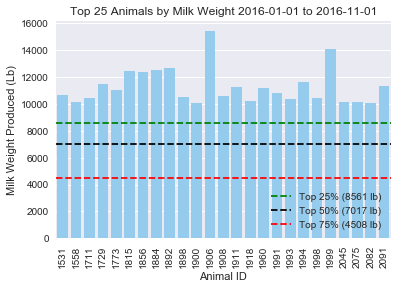

In [5]:
top_25 = int(milk_2016.quantile(0.75).values[0])
top_50 = int(milk_2016.quantile(0.50).values[0])
top_75 = int(milk_2016.quantile(0.25).values[0])

ax = plot_top_producers(milk, '2016-01-01', '2016-11-01')
top25 = ax.axhline(top_25, ls='--', c='green', label='Top 25%')
top50 = ax.axhline(top_50, ls='--', c='black', label='Top 50%')
top75 = ax.axhline(top_75, ls='--', c='red', label='Top 75%')
plt.legend([top25, top50, top75], 
           [f'Top 25% ({top_25} lb)', f'Top 50% ({top_50} lb)', f'Top 75% ({top_75} lb)'], 
           loc='lower right')
plt.savefig('../reports/figures/top_producer_2016.png')
plt.show()

In [6]:
top_producers_2016 = milk_2016.sort_values('milk_weight', ascending=False).head(25).index.values
top_producers_2016

array([1906, 1999, 1892, 1884, 1815, 1856, 1994, 1729, 2091, 1911, 1960,
       1773, 1991, 1531, 1908, 1898, 1711, 1998, 1993, 1918, 2045, 2075,
       1558, 1900, 2082])

## Top Producers for 2017

In [7]:
milk_2017 = monthly_sums_for_date_range(milk, '2017-01-01', '2017-11-01').groupby('animal_id').sum()

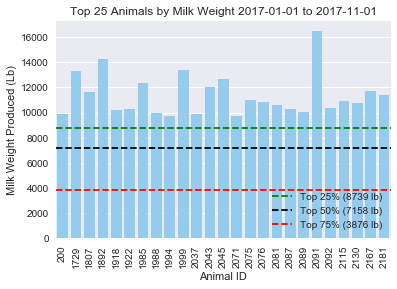

In [8]:
top_25 = int(milk_2017.quantile(0.75).values[0])
top_50 = int(milk_2017.quantile(0.50).values[0])
top_75 = int(milk_2017.quantile(0.25).values[0])

ax = plot_top_producers(milk, '2017-01-01', '2017-11-01')
top25 = ax.axhline(top_25, ls='--', c='green', label='Top 25%')
top50 = ax.axhline(top_50, ls='--', c='black', label='Top 50%')
top75 = ax.axhline(top_75, ls='--', c='red', label='Top 75%')
plt.legend([top25, top50, top75], 
           [f'Top 25% ({top_25} lb)', f'Top 50% ({top_50} lb)', f'Top 75% ({top_75} lb)'], 
           loc='lower right')
plt.savefig('../reports/figures/top_producer_2017.png')
plt.show()

In [9]:
top_producers_2017 = milk_2017.sort_values('milk_weight', ascending=False).head(25).index.values
top_producers_2017

array([2091, 1892, 1999, 1729, 2045, 1985, 2043, 2167, 1807, 2181, 2075,
       2115, 2076, 2130, 2081, 2092, 1922, 2087, 1918, 2089, 1988, 2037,
        200, 1994, 2071])

In [10]:

def build_top_performer_profiles_dataframe(genetics, score, top_perfomers):
    data = pd.merge(left=score, right=genetics, left_on='animal_id', right_on='animal_id').drop(columns=['index_x', 'index_y'])
    return data[data['animal_id'].isin(repeat_performers)]

def generate_animal_profiles(data):
    report_table = data[['animal_id', 
                         'body_condition', 
                         'front_end_capacity_aggregate', 
                         'dairy_strength_aggregate', 
                         'rump_aggregate', 
                         'feet_and_legs_aggregate', 
                         'udder_score_aggregate', 
                         'final_score', 
                         'breed_age_average',
                         'date', 
                         'milk', 
                         'ctpi']]

In [11]:
import numpy as np
repeat_performers = np.intersect1d(top_producers_2016, top_producers_2017)
top_profiles = build_top_performer_profiles_dataframe(genetics, score, repeat_performers)
top_profiles = top_profiles.sort_values('date').drop_duplicates(keep='last')
top_profiles = top_profiles.set_index('animal_id')
top_profiles = top_profiles[['final_score', 'breed_age_average', 'ctpi', 'date']]
top_profiles = top_profiles.rename(index=str, columns={"final_score": "Final Score",
                                                       "breed_age_average": "Breed Age Average",
                                                       "ctpi": "Type Performance Index",
                                                       "date": "Last Classification Date"})
top_profiles = top_profiles.reset_index()
milk_2016 = milk_2016.reset_index()
milk_2017 = milk_2017.reset_index()

print(milk_2016[milk_2016['animal_id'].isin(repeat_performers)])
print(milk_2017[milk_2017['animal_id'].isin(repeat_performers)])

top_profiles 

     animal_id  milk_weight
21        1729      11464.0
63        1892      12649.0
76        1918      10219.9
112       1994      11643.9
115       1999      14064.9
145       2045      10172.6
163       2075      10142.3
175       2091      11310.9
     animal_id  milk_weight
11        1729      13300.8
34        1892      14239.5
41        1918      10166.3
66        1994       9751.0
69        1999      13385.7
91        2045      12647.6
104       2075      10979.1
112       2091      16469.2


,animal_id,Final Score,Breed Age Average,Type Performance Index,Last Classification Date
0,1729.0,85.0,106.199997,1696,2014-08-05
1,1892.0,78.0,99.900002,1606,2014-08-05
2,1918.0,84.0,108.000000,1785,2014-08-05
3,1994.0,82.0,106.099998,1744,2015-03-09
4,1999.0,83.0,107.699997,2198,2015-03-09
5,1994.0,85.0,108.900002,1744,2015-10-18
6,1994.0,86.0,108.599998,1744,2016-05-09
7,2091.0,73.0,94.800003,1744,2016-05-09
8,2045.0,83.0,106.599998,1772,2016-05-09
9,2075.0,80.0,103.400002,1711,2016-05-09


In [12]:
top_25_2017

NameError: name 'top_25_2017' is not defined

In [ ]:
top_25_2016

In [ ]:
set(top_25_2017) & set(top_25_2016)

In [ ]:
from sklearn.preprocessing import normalize
merged_normal = normalize(merged)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_values = range(2, 11)
scores = []

for k in k_values:
    clusterer = KMeans(n_clusters=k, random_state=45)
    cluster_labels = clusterer.fit_predict(merged_normal)
    silhouette_avg = silhouette_score(merged_normal, cluster_labels)
    scores.append(silhouette_avg)
    
plt.plot(k_values, scores)
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
random_state = 25

animal_ids = merged.reset_index()['animal_id']
pca_components = PCA(n_components=3, random_state=random_state).fit_transform(merged_normal)
cluster_labels = KMeans(n_clusters=2, random_state=random_state).fit_predict(merged_normal)
x = pca_components[:,0]
y = pca_components[:,1]
z = pca_components[:,2]

results = pd.DataFrame({'cluster_id':cluster_labels, 'x':x, 'y':y, 'z':z}, index=animal_ids)
results = results.reset_index()
results.describe()
results['top_25'] = results['animal_id'].apply(lambda x: 1 if x in top_25 else 0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(results['x'], results['y'], results['z'], c=results['top_25'], marker='D')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

#plt.scatter(, c=, alpha=0.5)
#plt.show()

#plt.scatter(results['x'], results['y'], results['z'], c=, alpha=0.5, marker='D')
#plt.show()

In [ ]:
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN

In [ ]:
results = results.groupby('animal_id').mean().reset_index()

In [ ]:
results